<a href="https://colab.research.google.com/github/JackRich1/NV-cavity-QED/blob/main/MF_NV_Mag_Separate_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file creates two trainable models. One is responsible for filtering raw data from the MCG datasets created containing simulated measurements of the reflected MW signal the NV magnetometer measures for time series samples containing heartbeats and blank samples. This model is trained with a correlation based loss and aims to filter the raw samples such that they look like the original pre-processed MCG samples, which are trivial to classify. The second model is trained to classify samples as containing a heartbeat or not, for heartbeat detection, and makes use fo the trained filtration model within it.

In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 27.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.signal import decimate, find_peaks
import matplotlib.pyplot as plt
import wfdb
import os
from sklearn.preprocessing import StandardScaler

In [4]:

# Assumed constants and parameters (example values)
g_e = 2.00231930436256  # Electron g-factor
mu_B = 9.274009994e-24  # Bohr magneton (J/T)
h = 6.626e-34           # Planck constant (J·s)
base_frequency = 2.87e9 # Hz
gamma_true = 55e3       # Example gamma
gs_true = 0.019         # Example gs
k = 260e3
kc1 = 130e3
gammao = 2.23e3
Gamma = 330e3
Polarization = 0.1 # Just a placeholder, use correct values from your code
N = 1e18           # Placeholder, use from your code

def simulate_r2_numpy_vectorized(frequency, spin_freq, gamma, gs):
    # This function computes the reflected MW signal measured based on measurement frequency and true spin transition frequency
    # This is also dependent on system parameter estimates, which for now are limited to gamma (homogeneous linewidth) and gs (single coupling strength)
    h_np = 6.626e-34
    energy_d = h_np * frequency
    Delta = spin_freq - frequency
    g = np.sqrt(N * Polarization) * gs * 0.16
    alpha2 = 10 ** (-18 / 10) * 1e-3 / (energy_d * kc1 * 2 * np.pi) * (0.53 ** 2)
    beta2 = alpha2 * kc1
    chi_0 = np.sqrt(1 + 8*(gamma/gammao)*(gs**2)*alpha2/(gamma**2))
    Gamma_1_0 = Gamma + chi_0*gamma
    geff_0 = g/chi_0
    denom = (Delta - (g**2)*Delta/((Gamma_1_0/2)**2+Delta**2))**2 + \
            (k/2 + (geff_0**2)*(Gamma_1_0/2)/((Gamma_1_0/2)**2+Delta**2))**2
    term1 = kc1 * beta2
    alpha2_1 = term1/denom
    r2 = (-1 + np.sqrt(kc1 * alpha2_1 / beta2 + 1e-12))**2
    return r2

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

data_folder = '/content/drive/My Drive/MIT/MEng/MCG_data/subject1'

# Load the datasets
heartbeat_raw = np.load(os.path.join(data_folder, 'subject1_heartbeat_dataset_raw.npy'))
heartbeat_processed = np.load(os.path.join(data_folder, 'subject1_heartbeat_dataset_processed.npy'))

non_heartbeat_processed = np.load(os.path.join(data_folder, 'subject1_non_heartbeat_dataset_processed.npy'))
non_heartbeat_raw = np.load(os.path.join(data_folder, 'subject1_non_heartbeat_dataset_raw.npy'))  # Not required per request, but available

print("Heartbeat dataset raw shape:", heartbeat_raw.shape)
print("Heartbeat dataset processed shape:", heartbeat_processed.shape)
print("Non-heartbeat dataset processed shape:", non_heartbeat_processed.shape)
print("Non-heartbeat dataset raw shape:", non_heartbeat_raw.shape)

num_trials, beats_per_trial, raw_window_size = heartbeat_raw.shape
_, _, proc_window_size = heartbeat_processed.shape

# Check if raw_window_size is approximately 256 * proc_window_size
print("Raw window size:", raw_window_size)
print("Processed window size:", proc_window_size)
print("Expected raw_window_size should be approximately 256 * proc_window_size:", 256 * proc_window_size)

# This confirms that one segment in processed corresponds to the same time length as one segment in raw, just with 256x fewer samples.


Heartbeat dataset raw shape: (25, 40, 40960)
Heartbeat dataset processed shape: (25, 40, 160)
Non-heartbeat dataset processed shape: (25, 40, 160)
Non-heartbeat dataset raw shape: (25, 40, 40960)
Raw window size: 40960
Processed window size: 160
Expected raw_window_size should be approximately 256 * proc_window_size: 40960


Trial 0 has 40 valid heartbeat segments.


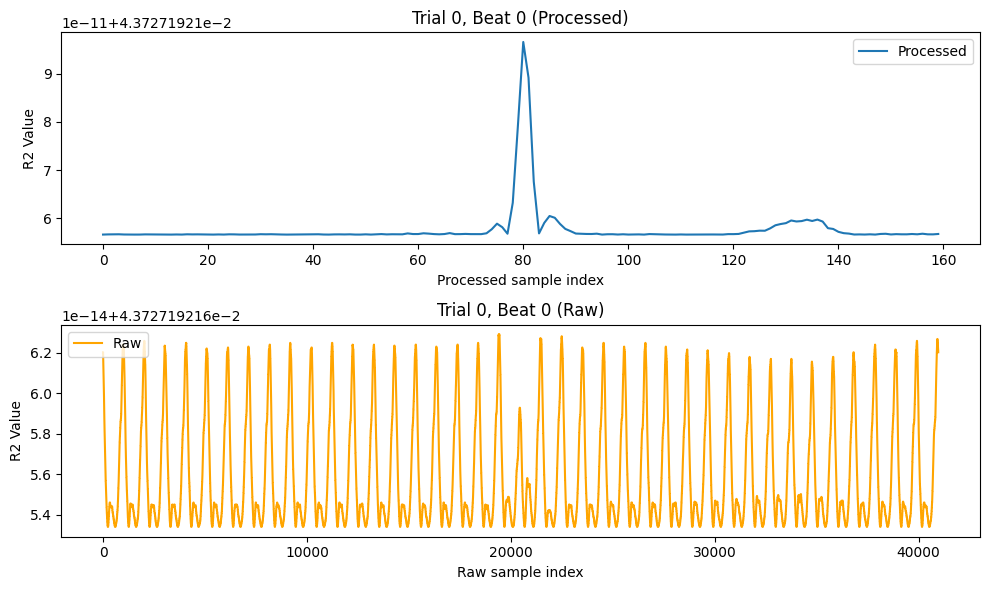

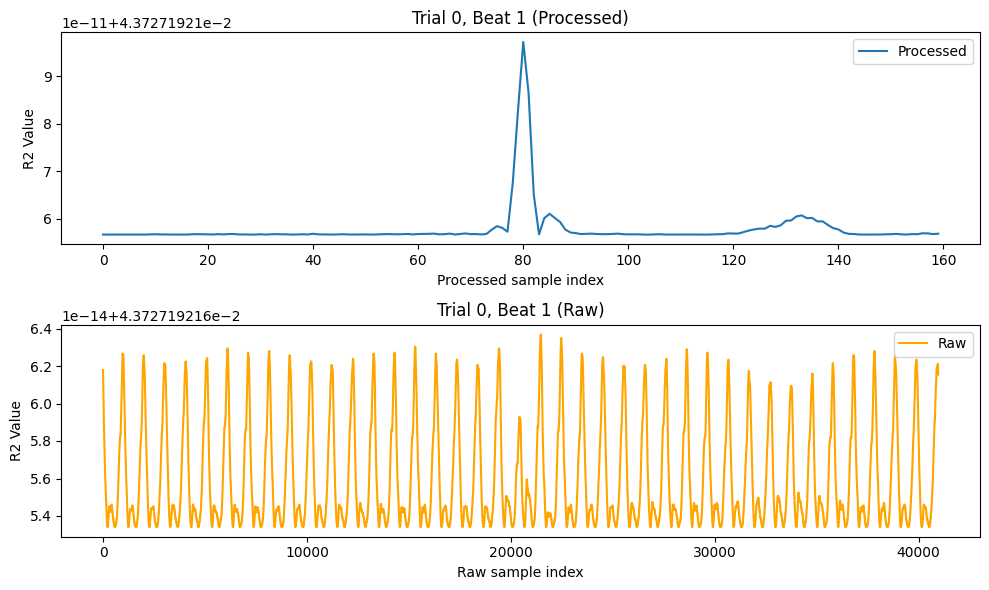

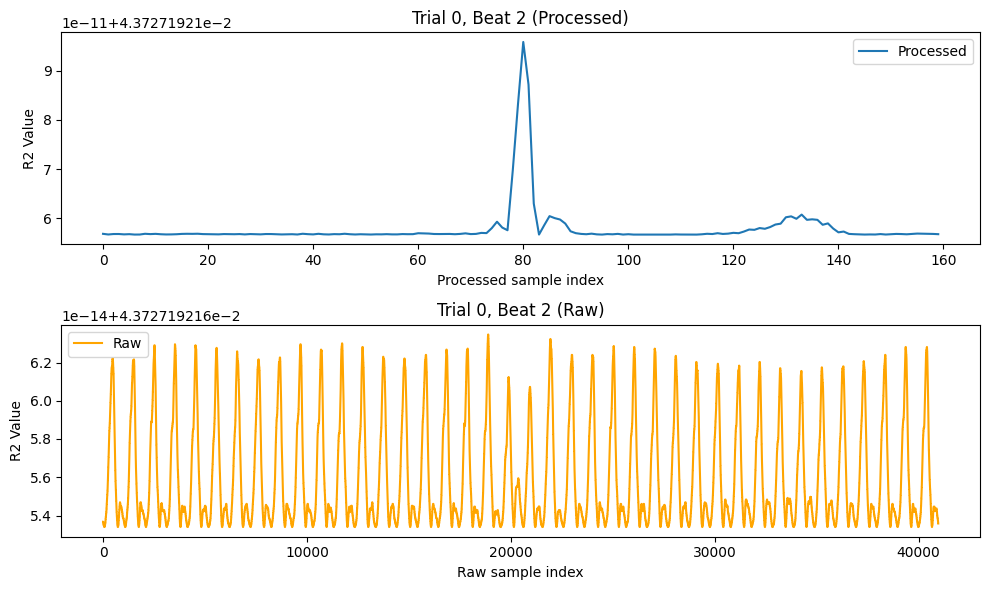

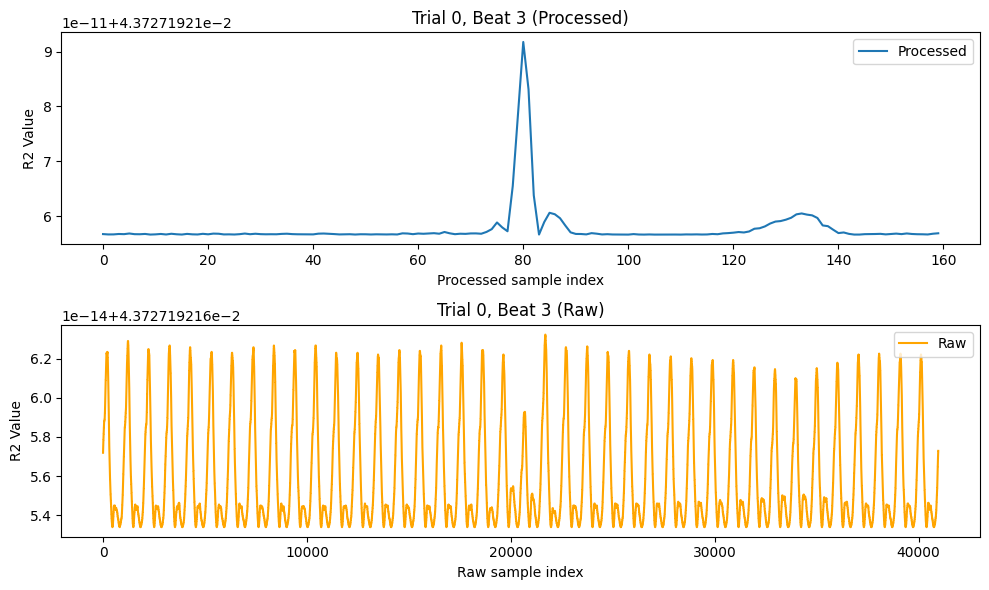

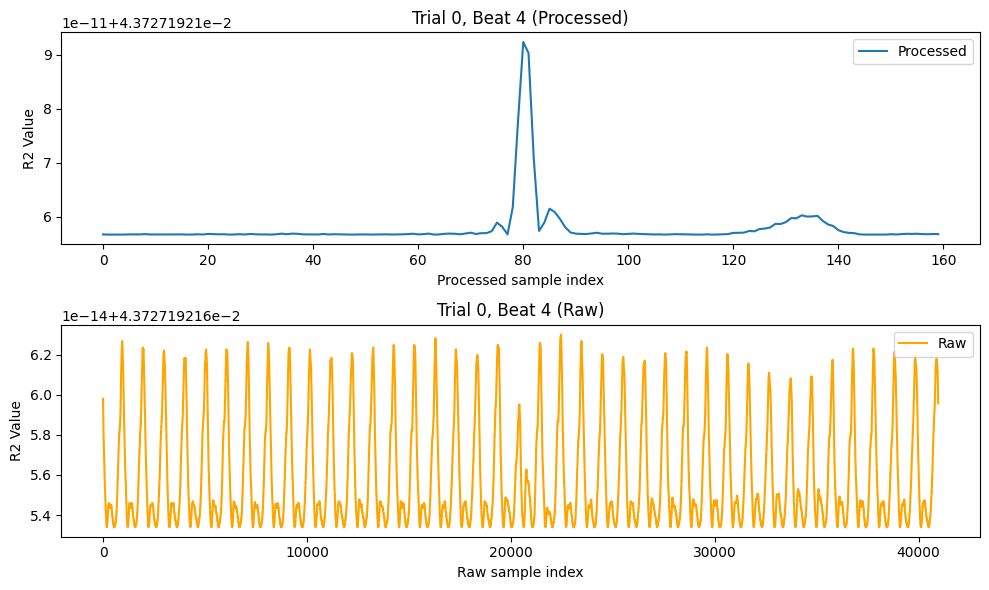

Trial 0 has 40 valid non-heartbeat segments.


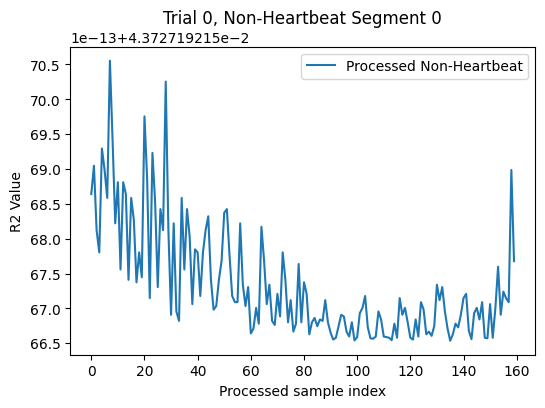

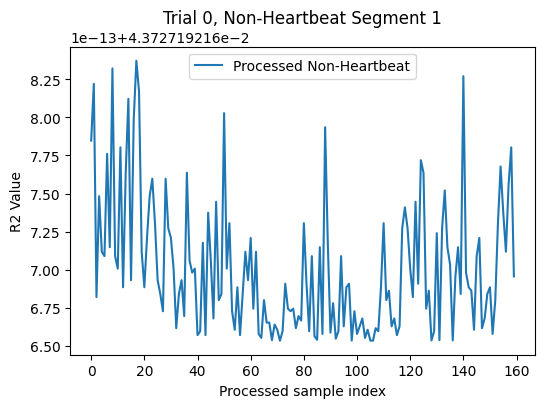

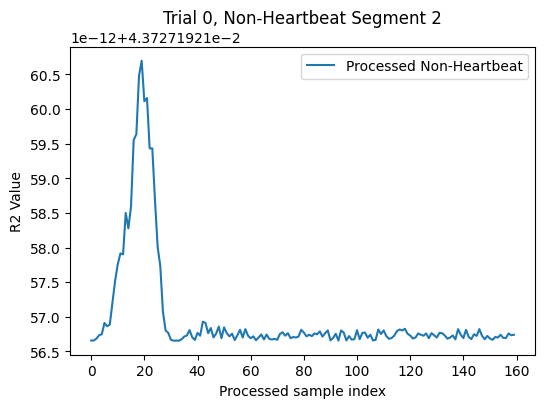

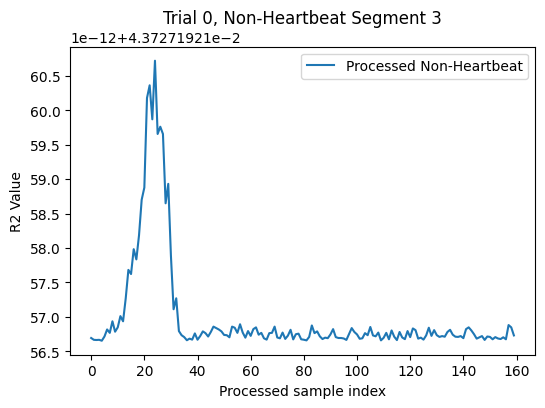

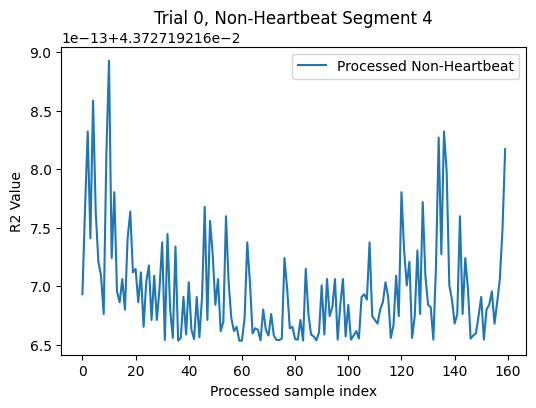

In [7]:
# Plotting a few samples to see what they look like
# We'll pick 5 random examples. For simplicity, let's just pick the first trial and first 5 beats that are non-zero (actually found).
trial_to_plot = 0  # you can change this if you'd like
valid_beats = np.where(~np.all(heartbeat_processed[trial_to_plot] == 0, axis=1))[0]  # indices of beats that are not all zeros
print(f"Trial {trial_to_plot} has {len(valid_beats)} valid heartbeat segments.")

# If fewer than 5 are found, we will just plot all that exist.
num_to_plot = min(5, len(valid_beats))

for i in range(num_to_plot):
    beat_idx = valid_beats[i]
    proc_segment = heartbeat_processed[trial_to_plot, beat_idx, :]
    raw_segment = heartbeat_raw[trial_to_plot, beat_idx, :]

    plt.figure(figsize=(10, 6))
    plt.subplot(2,1,1)
    plt.plot(proc_segment, label='Processed')
    plt.title(f'Trial {trial_to_plot}, Beat {beat_idx} (Processed)')
    plt.xlabel('Processed sample index')
    plt.ylabel('R2 Value')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(raw_segment, label='Raw', color='orange')
    plt.title(f'Trial {trial_to_plot}, Beat {beat_idx} (Raw)')
    plt.xlabel('Raw sample index')
    plt.ylabel('R2 Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

# By inspecting these plots, you should see a clear morphological similarity.
# The raw data should show a more detailed (higher resolution) version of the same event (heartbeat) seen in the processed data.

# Now let's plot some non-heartbeat segments (processed only)
non_heartbeat_trial_to_plot = 0
valid_non_beats = np.where(~np.all(non_heartbeat_processed[non_heartbeat_trial_to_plot] == 0, axis=1))[0]
print(f"Trial {non_heartbeat_trial_to_plot} has {len(valid_non_beats)} valid non-heartbeat segments.")

num_non_to_plot = min(5, len(valid_non_beats))

for i in range(num_non_to_plot):
    beat_idx = valid_non_beats[i]
    proc_segment = non_heartbeat_processed[non_heartbeat_trial_to_plot, beat_idx, :]

    plt.figure(figsize=(6,4))
    plt.plot(proc_segment, label='Processed Non-Heartbeat')
    plt.title(f'Trial {non_heartbeat_trial_to_plot}, Non-Heartbeat Segment {beat_idx}')
    plt.xlabel('Processed sample index')
    plt.ylabel('R2 Value')
    plt.legend()
    plt.show()



In [8]:
# Create dataloaders for filtration and classification datasets

from scipy.signal import decimate

heartbeats_flat_raw = heartbeat_raw.reshape(-1, heartbeat_raw.shape[-1])
non_heartbeats_flat_raw = non_heartbeat_raw.reshape(-1, non_heartbeat_raw.shape[-1])
heartbeats_flat_pre = heartbeat_processed.reshape(-1, heartbeat_processed.shape[-1])
non_heartbeats_flat_pre = non_heartbeat_processed.reshape(-1, non_heartbeat_processed.shape[-1])

# Create labels:
# Heartbeats are labeled 1, non-heartbeats are labeled 0
heartbeat_labels = np.ones((heartbeats_flat_pre.shape[0],), dtype=np.int64)
non_heartbeat_labels = np.zeros((non_heartbeats_flat_pre.shape[0],), dtype=np.int64)

# Concatenate heartbeats and non-heartbeats
X_raw = np.concatenate([heartbeats_flat_raw, non_heartbeats_flat_raw], axis=0)  # shape: (total_examples, window_size_raw)
X_pre = np.concatenate([heartbeats_flat_pre, non_heartbeats_flat_pre], axis=0)  # shape: (total_examples, window_size_pre)
y = np.concatenate([heartbeat_labels, non_heartbeat_labels], axis=0) # shape: (total_examples,)

# Apply z-score normalization
# scaler = StandardScaler()
# X_raw = scaler.fit_transform(X_raw)  # raw X now normalized to mean=0, std=1
# X_pre = scaler.fit_transform(X_pre)  # pre processed X now normalized to mean=0, std=1

# min max normalization
for i in range(X_raw.shape[0]):
    seg = X_raw[i]
    seg_min, seg_max = seg.min(), seg.max()
    X_raw[i] = (seg - seg_min) / (seg_max - seg_min + 1e-15)
    seg = X_pre[i]
    seg_min, seg_max = seg.min(), seg.max()
    X_pre[i] = (seg - seg_min) / (seg_max - seg_min + 1e-15)

downsample_factor = 40
X_raw = decimate(X_raw, downsample_factor, axis=1, zero_phase=True)

# Shuffle the combined dataset
perm = np.random.permutation(X_pre.shape[0])
X_raw = X_raw[perm]
X_pre = X_pre[perm]
y = y[perm]

# Convert to torch tensors
X_raw_tensor = torch.from_numpy(X_raw.copy()).float()  # convert to float tensor
X_pre_tensor = torch.from_numpy(X_pre.copy()).float()  # convert to float tensor
y_tensor = torch.from_numpy(y)          # labels as long (int64) tensors

# Optional: Add a channel dimension if needed by your model. For example, if you want (N, 1, T):
X_raw_tensor = X_raw_tensor.unsqueeze(1)  # Now shape is (N, 1, window_size_raw)
X_pre_tensor = X_pre_tensor.unsqueeze(1)  # Now shape is (N, 1, window_size_pre)

# Define a custom PyTorch Dataset
class HeartbeatDataset(Dataset):
    def __init__(self, X, y, noise_std=0.01):
        self.X = X
        self.y = y
        self.noise_std = noise_std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x, label = self.X[idx], self.y[idx]
        # Add noise
        noise = torch.randn_like(x) * self.noise_std
        x_noisy = x + noise
        return x_noisy, label

# Create the dataset
filter_dataset = HeartbeatDataset(X_raw_tensor, X_pre_tensor)
classification_dataset = HeartbeatDataset(X_raw_tensor, y_tensor)

# Split into train and validation sets
val_ratio = 0.2
val_size = int(len(filter_dataset) * val_ratio)
train_size = len(filter_dataset) - val_size

train_dataset_filter, val_dataset_filter = random_split(filter_dataset, [train_size, val_size])
train_dataset_classification, val_dataset_classification = random_split(classification_dataset, [train_size, val_size])

# Create dataloaders
batch_size = 64
train_loader_filter = DataLoader(train_dataset_filter, batch_size=batch_size, shuffle=True)
val_loader_filter = DataLoader(val_dataset_filter, batch_size=batch_size, shuffle=False)

train_loader_classification = DataLoader(train_dataset_classification, batch_size=batch_size, shuffle=True)
val_loader_classification = DataLoader(val_dataset_classification, batch_size=batch_size, shuffle=False)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from scipy.signal import firwin
import torch.optim as optim

In [11]:
def correlation_coefficient(pred, target):
    """
    pred, target: shape (batch_size, 1, time_length)
    Returns the mean correlation over the batch (scalar). Used for custon loss of the filtration model.
    """
    # Flatten along time for each example
    # shape (batch_size, time_length)
    pred_flat = pred.squeeze(1)
    target_flat = target.squeeze(1)

    pred_mean = pred_flat.mean(dim=1, keepdim=True)
    target_mean = target_flat.mean(dim=1, keepdim=True)

    pred_std = pred_flat.std(dim=1, keepdim=True) + 1e-9
    target_std = target_flat.std(dim=1, keepdim=True) + 1e-9

    # Zero-mean
    pred_zero = pred_flat - pred_mean
    target_zero = target_flat - target_mean

    # Correlation for each sample in batch
    # (pred_zero * target_zero).mean(dim=1) / (pred_std * target_std)
    corr_per_sample = (pred_zero * target_zero).mean(dim=1) / (pred_std * target_std).squeeze(1)

    # Mean correlation across the batch
    corr = corr_per_sample.mean()
    return corr


class CombinedLoss(nn.Module):
    """
    Weighted combination of MSE and correlation-based (shape) loss.
    Loss = alpha * MSE + (1 - alpha)*(1 - correlation_coefficient).
    Maximizing correlation -> Minimizing (1 - corr).
    """
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        # MSE
        mse_val = self.mse(pred, target)
        # correlation
        corr = correlation_coefficient(pred, target)

        # combined
        loss = self.alpha * mse_val + (1 - self.alpha) * (1 - corr)
        return loss

In [12]:

class FilterModel(nn.Module):
    """
    A simple CNN that maps raw r2 segments to pre-processed segments.
    You can expand layers, add more convs, etc. as desired.
    """
    def __init__(self, in_channels=1, out_channels=1, kernel_size=9, mid_channels=8, padding=4, final_length=160):
        super(FilterModel, self).__init__()
        # Example: 2 Conv1d layers
        self.conv1 = nn.Conv1d(in_channels, mid_channels, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(mid_channels, mid_channels, kernel_size=kernel_size, padding=padding)
        self.conv3 = nn.Conv1d(mid_channels, mid_channels*2, kernel_size=kernel_size, padding=padding)
        self.conv4 = nn.Conv1d(mid_channels*2, out_channels, kernel_size=kernel_size, padding=padding)

        self.final_length = final_length

    def forward(self, x):
        """
        x shape: (batch_size, 1, time_length_raw)
        returns shape: (batch_size, 1, time_length_pre)
        if input & output have same length, we keep them the same.
        If your raw/pre lengths differ, you might do other resizing or pad/truncation.
        """
        # Simple pipeline: Conv -> ReLU -> Conv
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = self.conv4(out)
        out_downsampled = F.interpolate(out, size=self.final_length, mode='linear', align_corners=False)
        return out_downsampled



In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_length = 160
trained_filter = FilterModel(in_channels=1, out_channels=1, kernel_size=5, mid_channels=8, padding=2, final_length=final_length).to(device)

criterion = CombinedLoss(alpha=0.1)
optimizer = optim.Adam(trained_filter.parameters(), lr=1e-3)

# Training loop
num_epochs = 25

for epoch in range(num_epochs):
    # ---- Training ----
    trained_filter.train()
    running_loss = 0.0
    total_samples = 0

    for X_batch_raw, X_batch_pre in train_loader_filter:
        # X_batch_raw shape: (batch_size, 1, raw_length)
        # X_batch_pre shape: (batch_size, 1, pre_length)
        # if raw_length != pre_length, you may need to handle that carefully (e.g. slice or pad)
        X_batch_raw = X_batch_raw.to(device)
        X_batch_pre = X_batch_pre.to(device)

        optimizer.zero_grad()
        predictions = trained_filter(X_batch_raw)  # shape ideally matches X_batch_pre

        loss = criterion(predictions, X_batch_pre)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch_raw.size(0)
        total_samples += X_batch_raw.size(0)

    train_loss = running_loss / total_samples

    # ---- Validation ----
    trained_filter.eval()
    val_loss = 0.0
    val_samples = 0

    with torch.no_grad():
        for X_val_raw, X_val_pre in val_loader_filter:
            X_val_raw = X_val_raw.to(device)
            X_val_pre = X_val_pre.to(device)

            preds = trained_filter(X_val_raw)
            loss_val = criterion(preds, X_val_pre)
            val_loss += loss_val.item() * X_val_raw.size(0)
            val_samples += X_val_raw.size(0)

    val_loss /= val_samples

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



Epoch [1/25] | Train Loss: 0.8772 | Val Loss: 0.8568
Epoch [2/25] | Train Loss: 0.8367 | Val Loss: 0.8206
Epoch [3/25] | Train Loss: 0.8058 | Val Loss: 0.7851
Epoch [4/25] | Train Loss: 0.7747 | Val Loss: 0.7702
Epoch [5/25] | Train Loss: 0.7531 | Val Loss: 0.7515
Epoch [6/25] | Train Loss: 0.7443 | Val Loss: 0.7458
Epoch [7/25] | Train Loss: 0.7334 | Val Loss: 0.7422
Epoch [8/25] | Train Loss: 0.7283 | Val Loss: 0.7275
Epoch [9/25] | Train Loss: 0.7249 | Val Loss: 0.7199
Epoch [10/25] | Train Loss: 0.7187 | Val Loss: 0.7195
Epoch [11/25] | Train Loss: 0.7182 | Val Loss: 0.7231
Epoch [12/25] | Train Loss: 0.7109 | Val Loss: 0.7113
Epoch [13/25] | Train Loss: 0.7027 | Val Loss: 0.7019
Epoch [14/25] | Train Loss: 0.7027 | Val Loss: 0.7026
Epoch [15/25] | Train Loss: 0.6966 | Val Loss: 0.7028
Epoch [16/25] | Train Loss: 0.6928 | Val Loss: 0.6916
Epoch [17/25] | Train Loss: 0.6962 | Val Loss: 0.6947
Epoch [18/25] | Train Loss: 0.6883 | Val Loss: 0.7051
Epoch [19/25] | Train Loss: 0.6869 | 

In [15]:
# Plot a few examples of the filtration model at work
import random
def plot_filter_examples(model, dataset, num_examples=5):
    """
    dataset: the same filter dataset (X_raw -> X_pre).
    We'll randomly sample 'num_examples' items, pass them through the model,
    and plot: raw, model-filtered, preprocessed.
    """
    model.eval()
    indices = random.sample(range(len(dataset)), num_examples)

    for i, idx in enumerate(indices):
        X_raw_tensor, X_pre_tensor = dataset[idx]
        # shapes: (1, time_length) each
        # remove batch/channel dims
        raw_np = X_raw_tensor.squeeze().numpy()
        pre_np = X_pre_tensor.squeeze().numpy()

        # Pass through model
        with torch.no_grad():
            inp = X_raw_tensor.unsqueeze(0).to(device)     # shape (1, 1, T)
            pred = model(inp)                              # shape (1, 1, T)
            pred_np = pred.squeeze().cpu().numpy()

        plt.figure(figsize=(10, 6))

        # Subplot 1: ground-truth preprocessed
        plt.subplot(3, 1, 1)
        plt.plot(pre_np, label='Pre-processed (dataset) ~200 Hz')
        plt.title(f"Example {idx} - Preprocessed")
        plt.legend()
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")

        # Subplot 2: raw r2 data (downsampled)
        plt.subplot(3, 1, 2)
        plt.plot(raw_np, color='orange', label='Raw r2 data')
        plt.title(f"Example {idx} - Raw r2 data")
        plt.legend()
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")

        # Subplot 3: model-filtered output
        plt.subplot(3, 1, 3)
        plt.plot(pred_np, color='green', label='Filtered (model output)')
        plt.title(f"Example {idx} - Model-filtered output")
        plt.legend()
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")

        plt.tight_layout()
        plt.show()


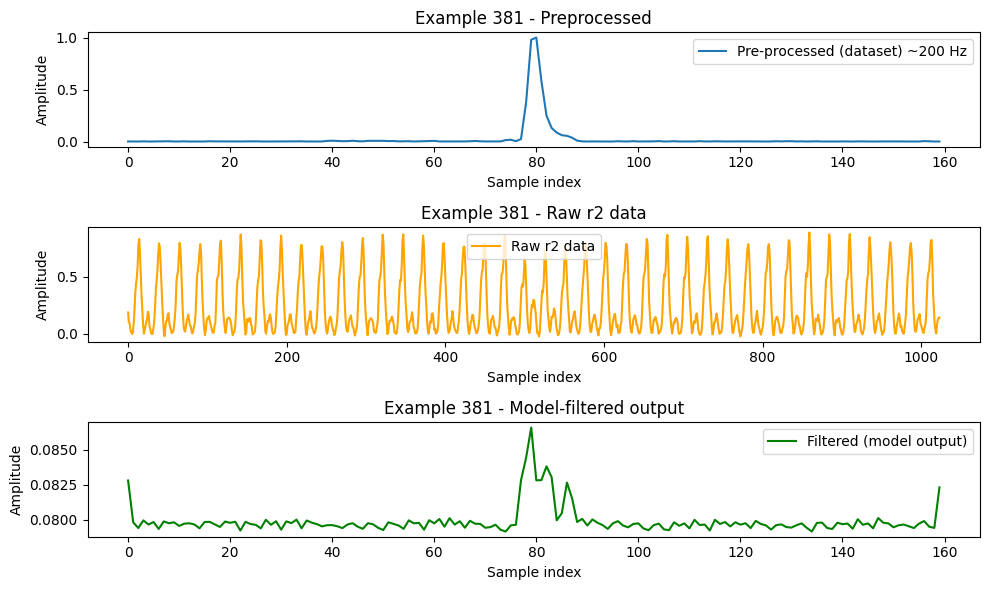

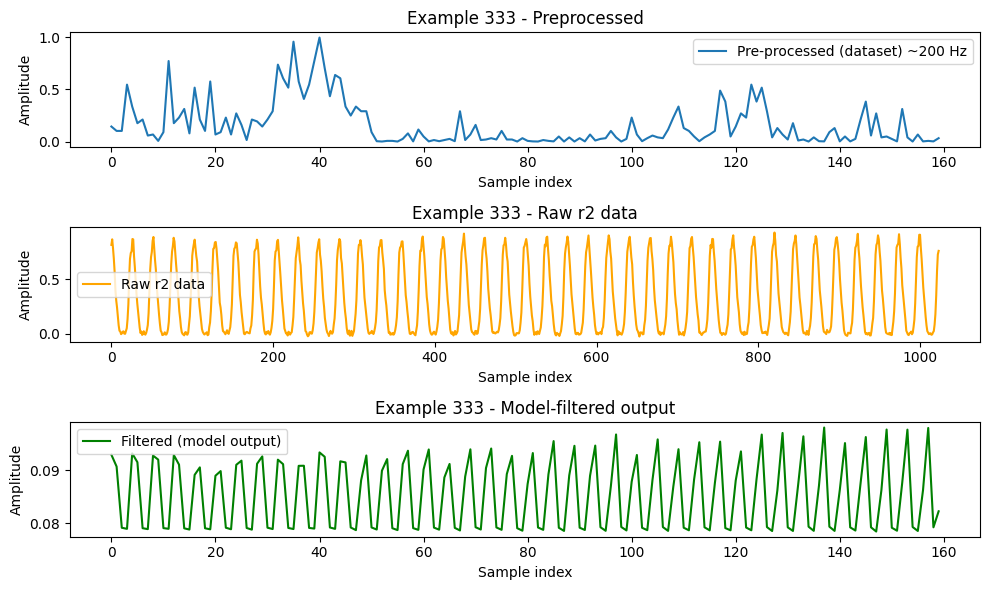

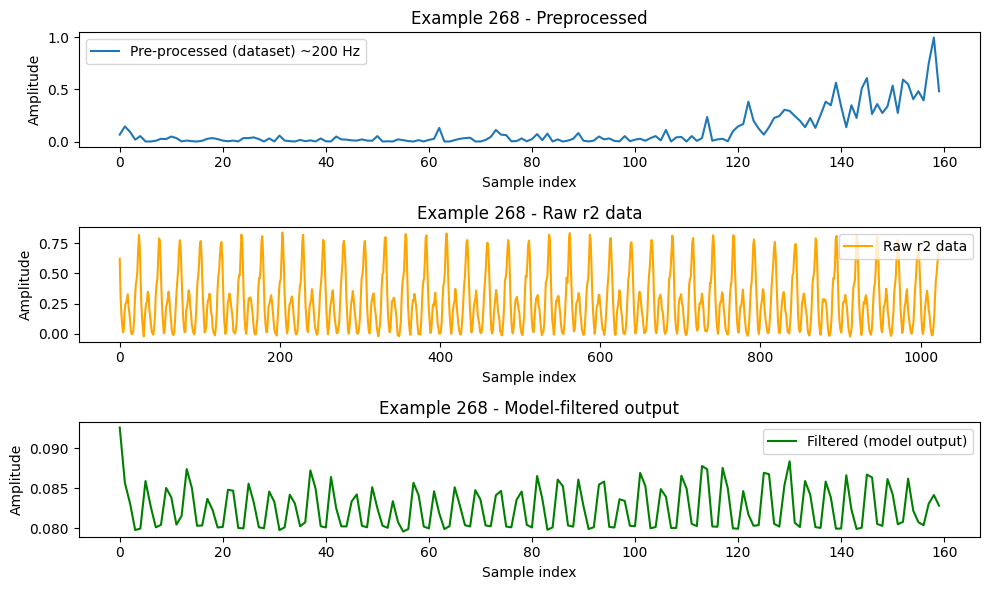

In [68]:
plot_filter_examples(trained_filter, val_dataset_filter, num_examples=3)

In [16]:

def compute_output_length(in_len, selective, freq_bins_range):
    """
    If selective=True and freq_bins_range is not None,
    output length after iFFT becomes (stop - start).
    Otherwise, length remains in_len.
    """
    if selective and freq_bins_range is not None:
        return freq_bins_range.stop - freq_bins_range.start
    else:
        return in_len


class SingleMFPass(nn.Module):
    """
    One pass that:
      - Convolution + ReLU in time domain.
      - If selective=True, also FFT -> slice freq bins -> iFFT back to time domain.
      - freq_bins_range can be None (don't slice) or a slice() object.
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=20,
        selective=False,
        freq_bins_range=None
    ):
        super().__init__()
        self.selective = selective
        self.freq_bins_range = freq_bins_range

        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            # padding=kernel_size // 2
            padding='same'
        )

    def forward(self, x_time):
        """
        x_time shape: (batch, in_channels, time_len).
        If selective=True, we do:
          time -> conv -> ReLU -> FFT -> slice -> iFFT -> time
        else just time -> conv -> ReLU.
        """
        # Time-domain convolution
        # print("before conv: " + str(x_time.shape))
        x_filtered = self.conv(x_time)  # (B, out_channels, T)
        # print("before relu: " + str(x_filtered.shape))
        x_filtered = F.relu(x_filtered)

        if self.selective:
            # Frequency transform
            x_freq = torch.fft.fft(x_filtered, dim=-1)  # (B, out_channels, T) complex
            # Slice
            if self.freq_bins_range is not None:
                x_freq = x_freq[:, :, self.freq_bins_range]  # e.g. slice(0,80)
            # print("after frequency selection: " + str(x_freq.shape))

            # Back to time domain
            x_time_out = torch.fft.ifft(x_freq, dim=-1)  # (B, out_channels, freq_len) complex
            x_time_out = torch.real(x_time_out)
            return x_time_out
        else:
            # Stay in time domain
            return x_filtered



In [24]:

class FullNetwork(nn.Module):
    """
    - num_passes: number of SingleAnalogPass layers.
    - base_out_channels: #channels for first pass (and possibly more, see channel_cap).
    - selective: if True, each pass does FFT->slice->iFFT.
    - freq_bins_ranges: list of slices (or None) for each pass. If you have fewer slices than passes, pass None.
    - channel_cap: if True, keeps out_channels the same each pass; if False, doubles channels each pass.
    - convert_to_freq: if True, final output is FFT (real+imag) before classifier.
    - raw_data: can inform kernel sizes or other hyperparams (example usage).
    """
    def __init__(
        self,
        filter_model,
        input_length,
        num_passes=2,
        base_out_channels=8,
        kernel_size=20,
        selective=False,
        freq_bins_ranges=None,   # list of length num_passes, each either slice(...) or None
        channel_cap=True,
        convert_to_freq=False,
    ):
        super().__init__()

        self.filter_model = filter_model

        self.num_passes = num_passes
        self.selective = selective
        self.channel_cap = channel_cap
        self.convert_to_freq = convert_to_freq

        # By default, if freq_bins_ranges is None, we create a list of None's (no slicing)
        if freq_bins_ranges is None:
            freq_bins_ranges = [None]*num_passes
        assert len(freq_bins_ranges) == num_passes, \
            "freq_bins_ranges must have same length as num_passes or be None."

        # Decide channels pass to pass
        out_channels_list = []
        current_ch = base_out_channels
        for i in range(num_passes):
            out_channels_list.append(current_ch)
            if not channel_cap:
                current_ch *= 2  # Example: double each pass

        # Build the passes, tracking dimension changes
        self.passes = nn.ModuleList()
        in_ch = 1
        current_time_len = input_length

        for i in range(num_passes):
            pass_out_ch = out_channels_list[i]
            pass_layer = SingleMFPass(
                in_channels=in_ch,
                out_channels=pass_out_ch,
                kernel_size=kernel_size,
                selective=selective,
                freq_bins_range=freq_bins_ranges[i]
            )
            self.passes.append(pass_layer)

            # Update channels for next pass
            in_ch = pass_out_ch

            # Update time dimension after this pass
            current_time_len = compute_output_length(
                current_time_len, selective, freq_bins_ranges[i]
            )

        self.final_time_length = current_time_len
        self.final_channels = out_channels_list[-1]

        # If we do convert_to_freq at the end, we will generate complex output => real+imag
        # -> effectively doubling the channel dimension for the classifier.
        if convert_to_freq:
            classifier_in_channels = 2 * self.final_channels
        else:
            classifier_in_channels = self.final_channels

        # total flatten size = channels * final_time_length
        fc_in_features = classifier_in_channels * self.final_time_length

        # Define classifier here in __init__
        hidden_dim = 128
        self.fc1 = nn.Linear(fc_in_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """
        x shape: (batch, 1, input_length) in time domain.
        Goes through multiple SingleAnalogPasses, then optionally do final FFT->split,
        flatten, and pass through FC layers.
        """
        with torch.no_grad():
            out = self.filter_model(x)
        # print("starting out: "+ str(out.shape))
        for module in self.passes:
            # print('starting a pass')
            # print("shape before pass : " + str(out.shape))
            out = module(out)  # remain (B, some_out_ch, some_time_len) in TIME domain
            # print("shape after pass : " + str(out.shape))

        if self.convert_to_freq:
            # Convert final time-domain output to frequency domain
            out = torch.fft.fft(out, dim=-1)  # (B, final_channels, final_time_length) complex
            # print("after convert to freq: "+str(out.shape))
            out_real = torch.real(out)
            out_imag = torch.imag(out)
            # Concat along channel dimension
            out = torch.cat([out_real, out_imag], dim=1)  # (B, 2*final_channels, final_time_length)
            # print("after concat: "+str(out.shape))

        # Flatten for classifier
        out_flat = out.reshape(out.size(0), -1)  # (B, classifier_in_features)
        # print("after flatten: "+str(out_flat.shape))

        # FC forward
        hidden = F.relu(self.fc1(out_flat))
        logits = self.fc2(hidden)  # (B, 1)
        return logits

In [37]:

selective = False         # whether each pass does FFT->slice->iFFT
num_passes = 2
freq_bins_ranges = [
    slice(0, 80),        # takes positive frequencies for pre-processed of len 160
    slice(0, 40)
]                       # If num_passes=2, must have 2 slices (or None)
channel_cap = False      # if False, channels increase each pass
convert_to_freq = True  # do final FFT before classifier
base_out_channels = 8
kernel_size =  21
input_length =  160

classifier = FullNetwork(
    filter_model=trained_filter,
    input_length=input_length,
    num_passes=num_passes,
    base_out_channels=base_out_channels,
    kernel_size=kernel_size,
    selective=selective,
    freq_bins_ranges=freq_bins_ranges,  # pass your list of slices or None
    channel_cap=channel_cap,
    convert_to_freq=convert_to_freq,
)
for param in classifier.filter_model.parameters():
    param.requires_grad = False

In [38]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier = classifier.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

def evaluate(classifier, loader, device):
    classifier.eval()
    total = 0
    correct = 0
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.float().to(device)

            logits = classifier(X_batch)
            loss = criterion(logits, y_batch.unsqueeze(1))

            running_loss += loss.item() * X_batch.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds.squeeze(1) == y_batch.long()).sum().item()
            total += X_batch.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [39]:


num_epochs = 20
for epoch in range(num_epochs):
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for X_batch, y_batch in train_loader_classification:
        X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)

        optimizer.zero_grad()
        logits = classifier(X_batch)       # forward
        loss = criterion(logits, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(logits) > 0.5).long()
        correct += (preds.squeeze(1) == y_batch.long()).sum().item()
        total += X_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = evaluate(classifier, val_loader_classification, device)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/20] | Train Loss: 0.6970, Train Acc: 0.5075 | Val Loss: 0.6908, Val Acc: 0.5450
Epoch [2/20] | Train Loss: 0.6913, Train Acc: 0.5106 | Val Loss: 0.6950, Val Acc: 0.4600
Epoch [3/20] | Train Loss: 0.6876, Train Acc: 0.5631 | Val Loss: 0.6813, Val Acc: 0.8225
Epoch [4/20] | Train Loss: 0.6752, Train Acc: 0.6044 | Val Loss: 0.6550, Val Acc: 0.6075
Epoch [5/20] | Train Loss: 0.6598, Train Acc: 0.5844 | Val Loss: 0.6741, Val Acc: 0.4750
Epoch [6/20] | Train Loss: 0.6282, Train Acc: 0.7456 | Val Loss: 0.5851, Val Acc: 0.9100
Epoch [7/20] | Train Loss: 0.5850, Train Acc: 0.7150 | Val Loss: 0.5601, Val Acc: 0.7000
Epoch [8/20] | Train Loss: 0.5313, Train Acc: 0.8306 | Val Loss: 0.4757, Val Acc: 0.9175
Epoch [9/20] | Train Loss: 0.4897, Train Acc: 0.8419 | Val Loss: 0.4278, Val Acc: 0.9075
Epoch [10/20] | Train Loss: 0.4461, Train Acc: 0.8819 | Val Loss: 0.4090, Val Acc: 0.9175
Epoch [11/20] | Train Loss: 0.4098, Train Acc: 0.8812 | Val Loss: 0.3435, Val Acc: 0.9025
Epoch [12/20] | Tra

1
-0.021503815
0.8590239
0
-0.025909951
0.84438354
1
-0.017367639
0.8899194
1
-0.03077059
0.8674406
0
-0.017596968
0.93564427


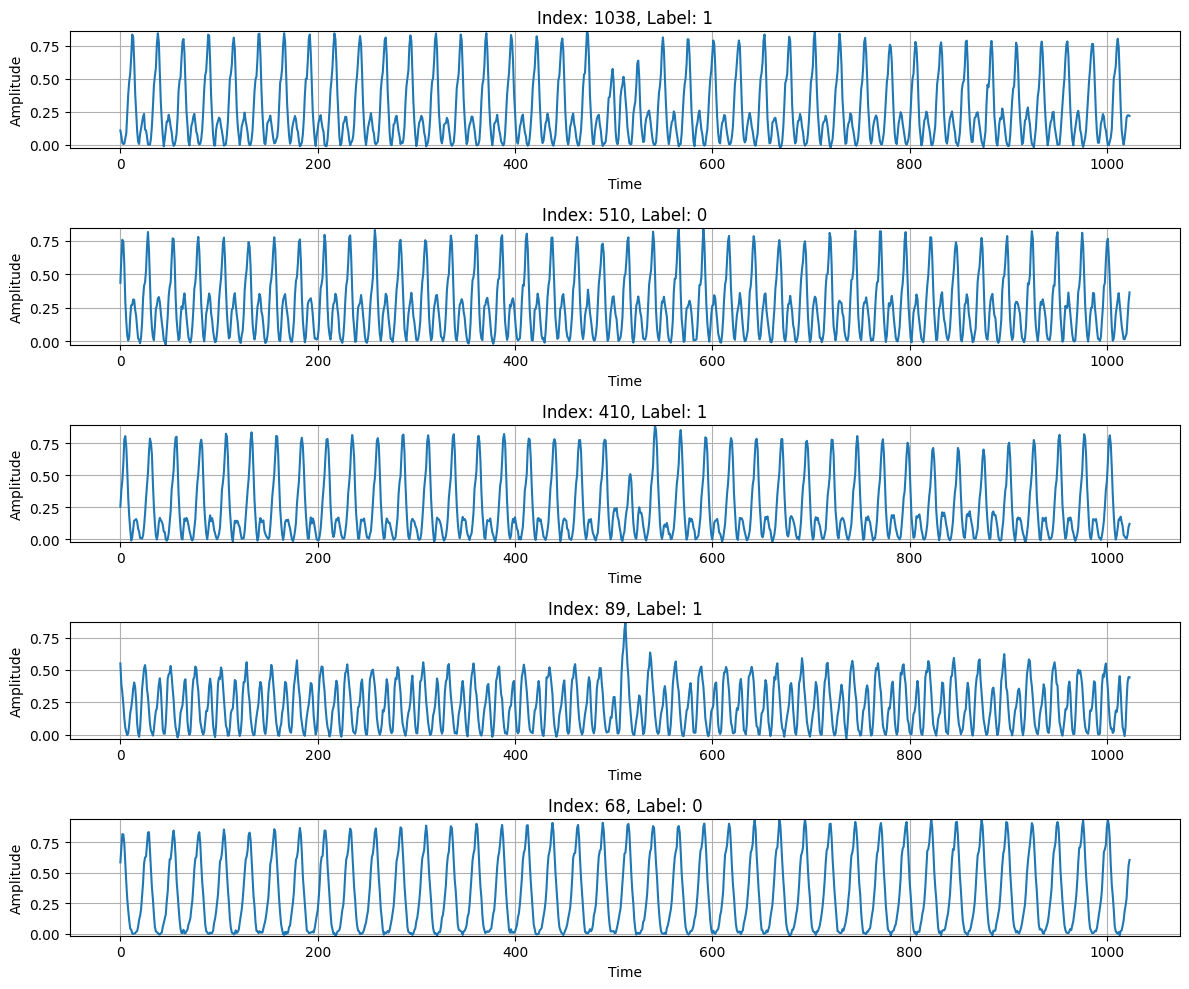

In [45]:
import random
import matplotlib.pyplot as plt

def plot_examples(dataset, num_examples=5):

    indices = random.sample(range(len(dataset)), num_examples)

    plt.figure(figsize=(12, 2*num_examples))

    for i, idx in enumerate(indices):
        X, y = dataset[idx]
        signal = X.squeeze().numpy()

        plt.subplot(num_examples, 1, i+1)
        plt.plot(signal)
        plt.title(f"Index: {idx}, Label: {y.item()}")

        # Auto-adjust y-limits based on data range
        ymin, ymax = signal.min(), signal.max()
        print(y.item())
        print(ymin)
        print(ymax)
        # if ymin == ymax:  # no variation
        #     epsilon = 1e-17 * abs(ymin) if ymin != 0 else 1e-6
        #     ymin -= epsilon
        #     ymax += epsilon
        plt.ylim([ymin, ymax])

        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_examples(train_dataset_classification, num_examples=5)